In [94]:
import pandas as pd, numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 
from catboost import *
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
import shap
from time import time

In [110]:
# ! pip install plotly 

### Loading Data

In [109]:
header = ["age",
"workclass",
"fnlwgt",
"education",
"education-num",
"marital-status","occupation","relationship","race",
"sex","capital-gain","capital-loss","hours-per-week",
"native-country",
"income"]

train = pd.read_csv("adult_data", names = header, index_col=False)

print(train.shape)

(32561, 15)


In [54]:
train.head(3)

age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   

        marital-status          occupation    relationship    race    sex  \
0        Never-married        Adm-clerical   Not-in-family   White   Male   
1   Married-civ-spouse     Exec-managerial         Husband   White   Male   
2             Divorced   Handlers-cleaners   Not-in-family   White   Male   

   capital-gain  capital-loss  hours-per-week  native-country  income  
0          2174             0              40   United-States   <=50K  
1             0             0              13   United-States   <=50K  
2             0             0              40   United-States   <=50K

In [55]:
train.shape

(32561, 15)

In [56]:
train["income"] = train["income"].apply(lambda x: 0 if x == " <=50K" else 1)

### Feature Importance

In [19]:
def log_loss(m, X, y): 
    return metrics.log_loss(y,m.predict_proba(X)[:,1])
    
def permutation_importances(model, X, y, metric):
    baseline = metric(model, X, y)
    imp = []
    for col in X.columns:
        save = X[col].copy()
        X[col] = np.random.permutation(X[col])
        m = metric(model, X, y)
        X[col] = save
        imp.append(m-baseline)
    return np.array(imp)

In [20]:
def baseline_importance(model, X, y, X_test, y_test, metric):
    
    model = CatBoostClassifier(one_hot_max_size = 10, iterations = 500)
    model.fit(X, y, cat_features = categorical_features_indices, verbose = False)
    baseline = metric(model, X_test, y_test)
    
    imp = []
    for col in X.columns:
        
        save = X[col].copy()
        X[col] = np.random.permutation(X[col])
        
        model.fit(X, y, cat_features = categorical_features_indices, verbose = False)
        m = metric(model, X_test, y_test)
        X[col] = save
        imp.append(m-baseline)
    return np.array(imp)
    

### Training Standard Model

In [71]:
X_train, X_test, y_train, y_test = train_test_split(train.drop("income", axis = 1), train["income"], \
                                                    train_size=0.7, random_state=1)

In [72]:
categorical_features_indices = [1, 3, 5, 6, 7, 8, 9, 13]

In [116]:
for col in X_train.columns:
    print(col, X_train[col].nunique())

age 73
workclass 9
fnlwgt 16640
education 16
education-num 16
marital-status 7
occupation 15
relationship 6
race 5
sex 2
capital-gain 116
capital-loss 88
hours-per-week 93
native-country 41


In [24]:
iteration = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]
loss = []
for i in iteration:
    model = CatBoostClassifier(one_hot_max_size = 10, iterations = i)
    model.fit(
    X_train, y_train,
    cat_features = categorical_features_indices,
    verbose = False
    )
    loss.append((i, log_loss(model, X_test, y_test), log_loss(model, X_train, y_train)))
    print(i)

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800


<function matplotlib.pyplot.show>

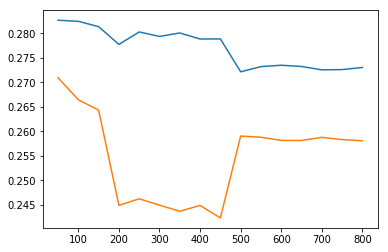

In [25]:
plt.plot([i[0] for i in loss],[i[1] for i in loss]) 
plt.plot([i[0] for i in loss],[i[2] for i in loss]) 
plt.show

In [73]:
model = CatBoostClassifier(one_hot_max_size = 10, iterations = 500)
model.fit(
    X_train, y_train,
    cat_features = categorical_features_indices,
    verbose = False
)

In [50]:
# model.get_feature_importance??

### Shap Values

In [27]:
shap_values = model.get_feature_importance(Pool(X_test, label=y_test,cat_features=categorical_features_indices), 
                                                                     type="ShapValues")
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], X_test.iloc[3,:])

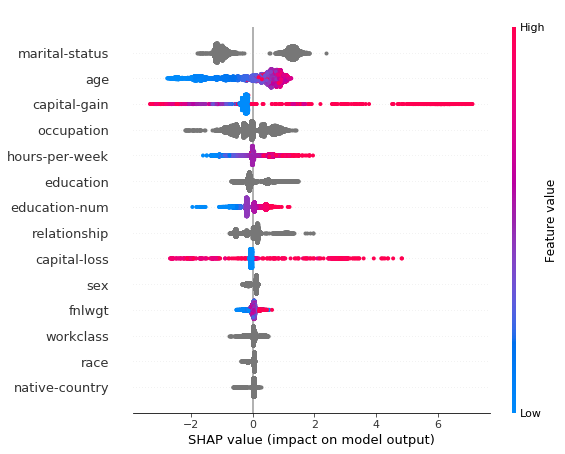

In [82]:
start_time = time.time()
shap_values = model.get_feature_importance(Pool(X_test, label=y_test,cat_features=categorical_features_indices), 
                                                                     type="ShapValues")
shap_values = shap_values[:,:-1]

shap.summary_plot(shap_values, X_test) 
elapsed = time.time() - start_time

In [83]:
elapsed

2.246151924133301

In [79]:
timeit.default_timer()

770830.962590046

In [87]:
def get_feature_imp_plot(method):
    
    if method == "Permutation":
        fi =  permutation_importances(model, X_test, y_test, log_loss)
    
    elif method == "Baseline":
        fi = baseline_importance(model, X_train, y_train, X_test, y_test, log_loss)
    
    elif method == "ShapeValues":
        shap_values = model.get_feature_importance(Pool(X_test, label=y_test,cat_features=categorical_features_indices), 
                                                                     type="ShapValues")
        shap_values = shap_values[:,:-1]
        shap.summary_plot(shap_values, X_test) 
        
    else:
        fi = model.get_feature_importance(Pool(X_test, label=y_test,cat_features=categorical_features_indices), 
                                                                     type=method)
        
    if method != "ShapeValues":
        feature_score = pd.DataFrame(list(zip(X_test.dtypes.index, fi )),
                                        columns=['Feature','Score'])

        feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

        plt.rcParams["figure.figsize"] = (12,7)
        ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
        ax.set_title("Feature Importance using {}".format(method), fontsize = 14)
        ax.set_xlabel("features")
        plt.show()

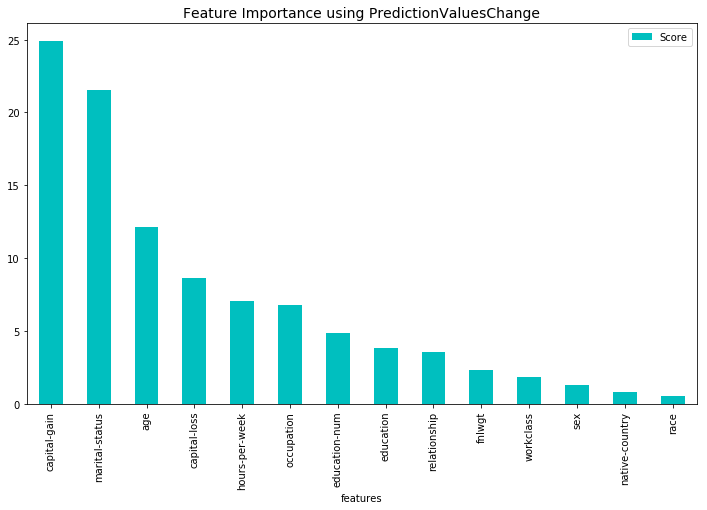

CPU times: user 281 ms, sys: 27.2 ms, total: 308 ms
Wall time: 313 ms


In [99]:
%time get_feature_imp_plot(method="PredictionValuesChange")

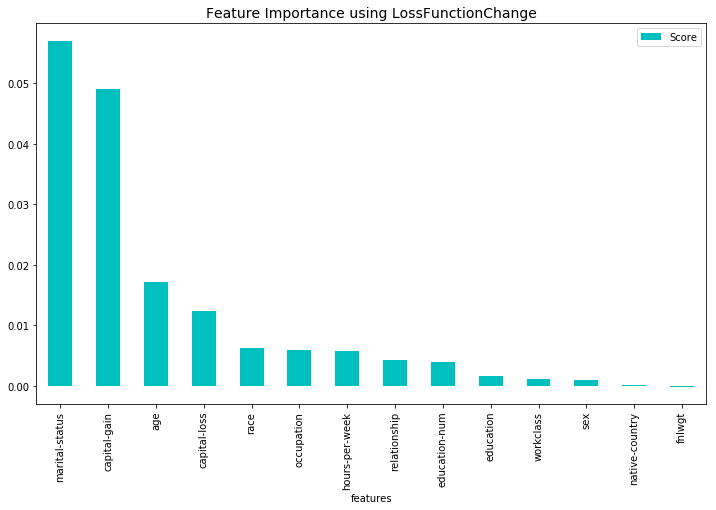

CPU times: user 2.03 s, sys: 31.3 ms, total: 2.06 s
Wall time: 514 ms


In [100]:
%time get_feature_imp_plot(method="LossFunctionChange")

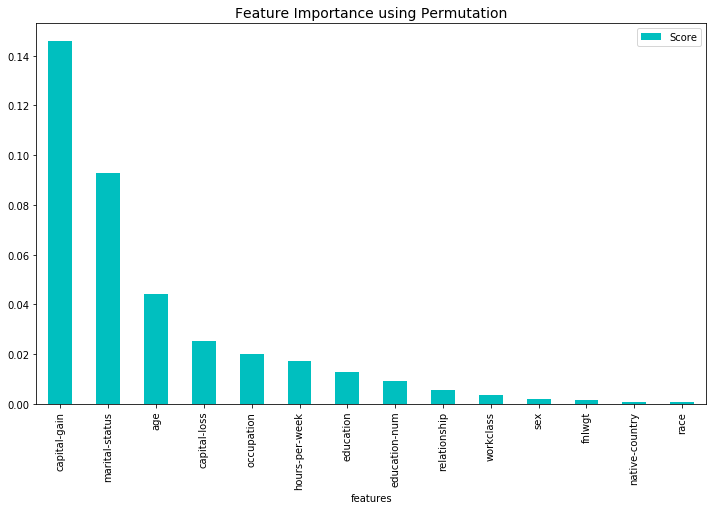

CPU times: user 1.27 s, sys: 137 ms, total: 1.4 s
Wall time: 1.08 s


In [101]:
%time get_feature_imp_plot(method="Permutation")

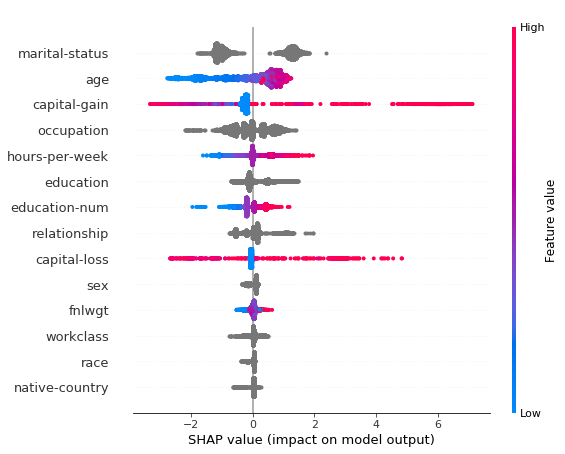

CPU times: user 3.86 s, sys: 50.1 ms, total: 3.91 s
Wall time: 2.29 s


In [102]:
%time get_feature_imp_plot(method="ShapeValues")

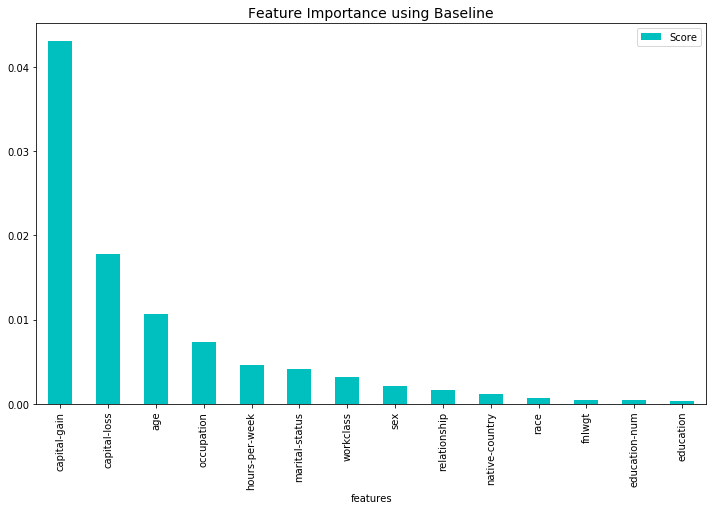

CPU times: user 25min 19s, sys: 6min 25s, total: 31min 45s
Wall time: 5min 32s


In [33]:
%time get_feature_imp_plot(method="Baseline")

### Interaction Feature Importance

In [206]:
fi = model.get_feature_importance(Pool(X_test, label=y_test,cat_features=categorical_features_indices), 
                                                                     type="Interaction")

Dataset is provided, but Interaction feature importance don't use it.


In [207]:
fi[:5]

[[5, 10, 4.879359239300689],
 [7, 11, 4.211308589799566],
 [1, 7, 3.596972913690984],
 [6, 10, 3.56524055924632],
 [5, 6, 3.4918909052689524]]

In [208]:
fi_new = []
for k,item in enumerate(fi):  
    first = X_test.dtypes.index[fi[k][0]]
    second = X_test.dtypes.index[fi[k][1]]
    if first != second:
        fi_new.append([first + "_" + second, fi[k][2]])

In [210]:
fi_new[:5]

[['marital-status_capital-gain', 4.879359239300689],
 ['relationship_capital-loss', 4.211308589799566],
 ['workclass_relationship', 3.596972913690984],
 ['occupation_capital-gain', 3.56524055924632],
 ['marital-status_occupation', 3.4918909052689524]]

In [213]:
feature_score = pd.DataFrame(fi_new,columns=['Feature-Pair','Score'])

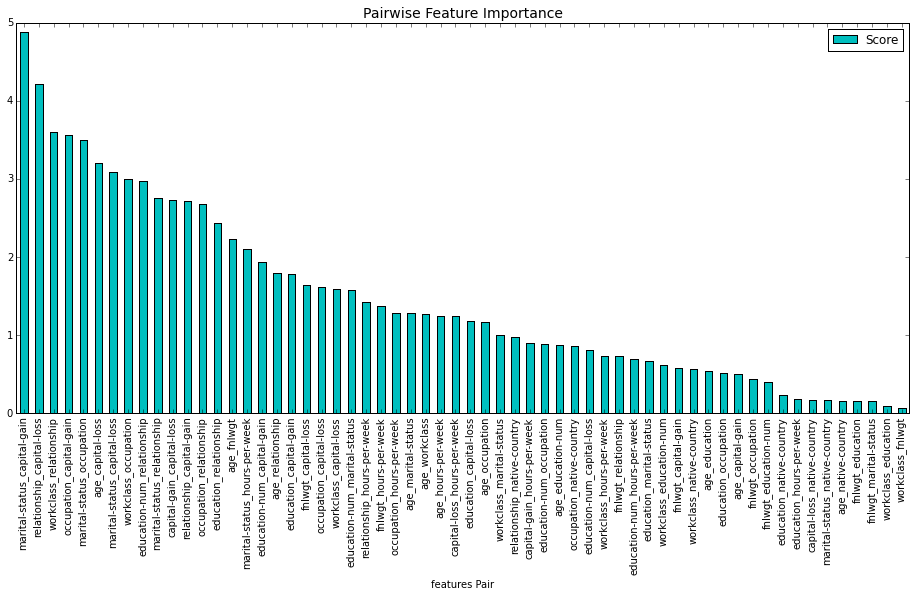

In [215]:
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')
plt.rcParams["figure.figsize"] = (16,7)
ax = feature_score.plot('Feature-Pair', 'Score', kind='bar', color='c')
ax.set_title("Pairwise Feature Importance", fontsize = 14)
ax.set_xlabel("features Pair")
plt.show()

## Plots for Model Analysis

#### Numerical Feature

In [113]:
feature = 'hours-per-week'
res = model.get_feature_statistics(X_train, y_train, feature, plot=True)

#### One-Hot Feature

In [117]:
feature = 'workclass'
model.get_feature_statistics(X_train, y_train, feature, plot=True)

{'binarized_feature': array([8, 0, 1, ..., 0, 6, 0]),
 'mean_target': array([0.22366841, 0.1033411 , 0.2920592 , 0.        , 0.3948949 ,
        0.        , 0.29469123, 0.28923768, 0.57639754], dtype=float32),
 'mean_prediction': array([0.22334838, 0.10167585, 0.3016555 , 0.05339337, 0.37704837,
        0.01450176, 0.30424172, 0.2946237 , 0.56375426], dtype=float32),
 'objects_per_bin': array([15827,  1287,  1486,     9,   666,     5,   923,  1784,   805],
       dtype=uint32),
 'predictions_on_varying_feature': array([0.25023816, 0.24915191, 0.23332911, 0.18895106, 0.28084712,
        0.22534325, 0.24529697, 0.21784215, 0.2707088 , 0.        ]),
 'cat_values': array([' Private', ' ?', ' Local-gov', ' Without-pay', ' Federal-gov',
        ' Never-worked', ' State-gov', ' Self-emp-not-inc',
        ' Self-emp-inc'], dtype='<U17')}

In [ ]:
feature = 'sex'
res = titanic_model.calc_feature_statistics(titanic_train, titanic_train_target, feature, plot=True)

In [107]:
model.get_feature_statistics?